In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt  
import numpy as np
import logging
from datetime import datetime
import funs

current_date = datetime.now().strftime("%Y-%m-%d")

logging.basicConfig(
    filename=f'logs/Isolation_forest_{current_date}.log',
    filemode='a',
    format='%(message)s', 
    level=logging.INFO
)

formatter = logging.Formatter('%(asctime)s ', datefmt='%Y-%m-%d %H:%M:%S')

def log(txt, level="info"):
    txt = str(txt)

    if level == "start":
        # Tworzy rekord loga ręcznie i formatujemy go jako tekst
        record = logging.LogRecord(name="log", level=logging.INFO, pathname="", lineno=0, msg="", args=(), exc_info=None)
        
        log_header = formatter.format(record)
        
        
        num = int((102 - len(txt))/2)
        if(num <= 0):
            num = 1 

        ending ='-' * num
            
        logging.info("\n\n<-" + ending +"[LOG] " + log_header + txt +" [LOG]" + ending + "->")  
    else:
        logging.info(txt)
        print(txt)


log("START",level = "start")

<div style="
    text-align: center;
    font-weight: bold;
    font-size: 52px;
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    margin-top: 50px;
    margin-bottom: 30px;
    padding: 25px 0;
    color: #ffffff;
    background: linear-gradient(90deg, #0f0f0f 0%, #1e1e1e 100%);
    border-top: 4px solid #4ec9b0;
    border-bottom: 4px solid #4ec9b0;
    box-shadow: 0 0 100px rgba(78, 201, 176, 0.3), 0 2px 10px rgba(0,0,0,0.6);
    letter-spacing: 1px;
">
  Przygotowanie danych
</div>




<div style="text-align: center; font-weight: bold; font-size: 35px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 30px; margin-bottom: 20px; padding: 10px 0; border-top: 2px solid #666; border-bottom: 2px solid #666;">
  Przygotowania danych normalnego ruchu do trenowania modelu
</div>

<div style="font-size: 30px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 20px; line-height: 1.6;">
<ul style="margin-left: 20px;">
    1. df_1 – Monday-WorkingHours.pcap_ISCX.csv
  </ul>
</div>


In [2]:
# Wczytanie danych
df = pd.read_csv("../datasets/CIC-IDS2017/MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv", low_memory=False)
print("Lenght of dataframe befour preperation: ")
print(len(df))

df.columns = df.columns.str.strip()
print("Droping Lable and redundancy")
df = df.drop(["Fwd Header Length.1", "Label"], axis = 1)
print("Number of NANS")
print(df.isna().any(axis=1).sum())
#df.info()


#df = df.drop_duplicates()


num_cols = df.select_dtypes(include=[np.number]).columns
inf_mask = np.isinf(df[num_cols])
columns_with_inf = df.columns[inf_mask.any()]
print("Colums with inf: ")
print(columns_with_inf.tolist())

df.replace([np.inf, -np.inf], np.nan, inplace=True)

print("Number of NANS and infs: ")
print(df.isna().any(axis=1).sum())
df.dropna(inplace=True)
df = df.reset_index(drop=True)
print("Lenght of dataframe after preperation: ")
print(len(df))

Lenght of dataframe befour preperation: 
529918
Droping Lable and redundancy
Number of NANS
64
Colums with inf: 
['Flow Bytes/s', 'Flow Packets/s']
Number of NANS and infs: 
437
Lenght of dataframe after preperation: 
529481


<div style="margin-left: 38px; font-size: 30px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 20px; line-height: 1.6;">
    <div>1.2 Skalowanie danych</div>
</div>

In [3]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df),
    columns=df.columns  
)

<div style="margin-left: 38px; font-size: 30px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 20px; line-height: 1.6;">
    <div>1.3 Skalowanie danych - wizualizacja dzialania skalowania</div>
</div>

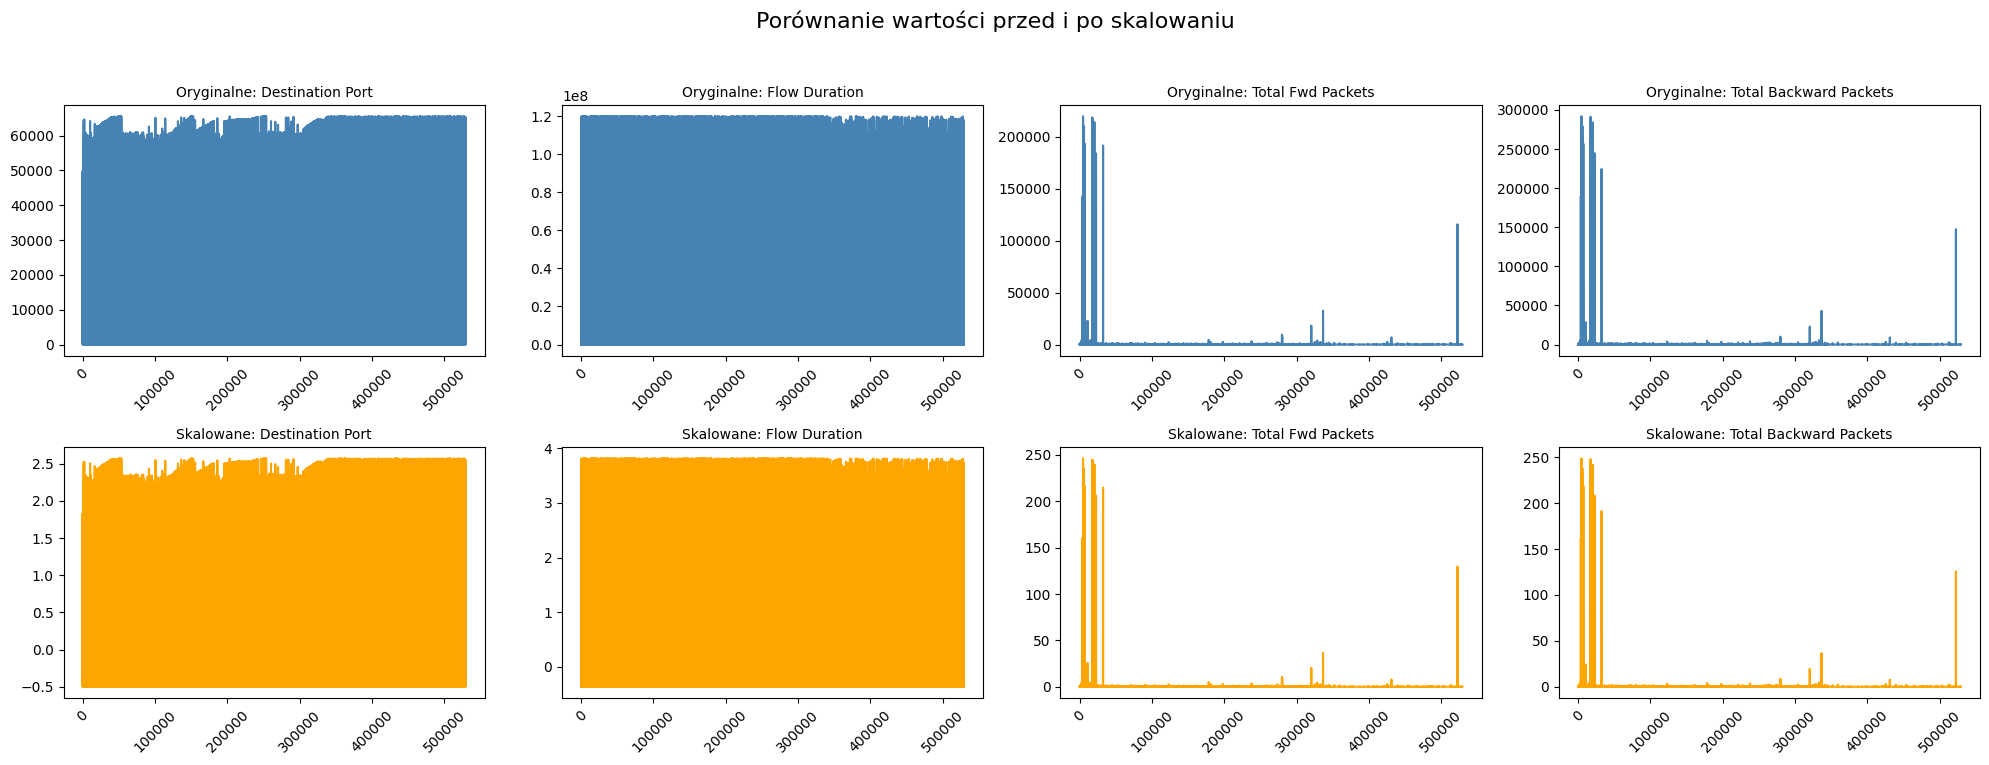

Series([], Name: Total Fwd Packets, dtype: float64)


In [4]:
columns_to_plot = df.columns[:4]

# Ustawienia siatki 2x4 (2 wiersze: oryginał, skalowane)
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
fig.suptitle("Porównanie wartości przed i po skalowaniu", fontsize=16)

for i, col in enumerate(columns_to_plot):
    # Oryginalne dane - wykres liniowy
    axes[0, i].plot(df[col].values, color='steelblue')
    axes[0, i].set_title(f"Oryginalne: {col}", fontsize=10)
    axes[0, i].tick_params(axis='x', rotation=45)

    # Skalowane dane - wykres liniowy
    axes[1, i].plot(df_scaled[col].values, color='orange')
    axes[1, i].set_title(f"Skalowane: {col}", fontsize=10)
    axes[1, i].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print(df_scaled[df_scaled["Total Fwd Packets"] > 500]["Total Fwd Packets"])


<div style="text-align: center; font-weight: bold; font-size: 35px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 30px; margin-bottom: 20px; padding: 10px 0; border-top: 2px solid #666; border-bottom: 2px solid #666;">
  Przygotowanie dataframe'ów testowych zawierająch różne ataki
</div>



<div style="font-size: 30px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 20px; line-height: 1.6;">
    <li>2. Przygotowanie danych z Tuesday-WorkingHours.pcap_ISCX.csv</li>
    <ul style="margin-left: 15px;">
        <li>df_2 - dane "Tuesday-WorkingHours"</li>
        <li>df_2_5 - dane "Tuesday-WorkingHours" tylko z brut forcem</li>
    </ul>
</div>

In [5]:
# Wczytanie danych
df_2 = pd.read_csv("../datasets/CIC-IDS2017/MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv", low_memory=False)

df_2.columns = df_2.columns.str.strip()
df_2 = df_2.drop(["Fwd Header Length.1"], axis = 1)


#df_2 = df_2.drop_duplicates()


len_1 = len(df_2)
nans = df_2.isna().any(axis=1).sum()
print("Number of flows: " , len(df_2))
print("Number of flows labled FTP - Patator: ", df_2['Label'].str.contains('FTP-Patator', na=False).sum())
print("Number of flows with NAN: " , nans)

df_2.replace([np.inf, -np.inf], np.nan, inplace=True)
infs = df_2.isna().any(axis=1).sum() - nans
print("Number of flows with inf or -inf : " , infs)

df_2.dropna(inplace=True)
print("Number of flows labled FTP - Patator after deleting NANs and INFs: ", df_2['Label'].str.contains('FTP-Patator', na=False).sum())
len_2 = len_1 - len(df_2)
print(len_2, "Flows deleted ,","flows in Tuesday-WorkingHours after preparation : ", len(df_2) )
print("\nCreating df_2_5 with everything that is labled having FTP brut force")


df_2_5 = df_2[df_2['Label'].str.contains('FTP-Patator', na=False)]
df_2_5 = df_2_5.drop(["Label"], axis = 1)
df_2_5 = df_2_5.reset_index(drop=True)
print("number of flows in final df_2_5 test dataframe : ", len(df_2_5))

df_2_labels = df_2["Label"]
df_2 = df_2.drop(["Label"], axis = 1)
df_2_labels = df_2_labels.reset_index(drop=True)
df_2 = df_2.reset_index(drop=True)

Number of flows:  445909
Number of flows labled FTP - Patator:  7938
Number of flows with NAN:  201
Number of flows with inf or -inf :  63
Number of flows labled FTP - Patator after deleting NANs and INFs:  7935
264 Flows deleted , flows in Tuesday-WorkingHours after preparation :  445645

Creating df_2_5 with everything that is labled having FTP brut force
number of flows in final df_2_5 test dataframe :  7935


<div style="font-size: 30px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 20px; line-height: 1.6;">
    <li>3. Przygotowanie danych z Wednesday-WorkingHours.pcap_ISCX.csv</li>
    <ul style="margin-left: 15px;">
        <li>df_3 - dane "Wednesday-WorkingHours"</li>
        <li>df_3_5 - dane "Wednesday-WorkingHours" tylko z różnymi atakami</li>
    </ul>
</div>

In [6]:
df_3 = pd.read_csv("../datasets/CIC-IDS2017/MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv", low_memory=False)

df_3.columns = df_3.columns.str.strip()
df_3 = df_3.drop(["Fwd Header Length.1"], axis = 1)


#df_3 = df_3.drop_duplicates()


len_1 = len(df_3)
nans = df_3.isna().any(axis=1).sum()
print("Number of flows: " , len(df_3))
print("Number of flows labled as Attac: ", (~df_3['Label'].str.contains('BENIGN', na=False)).sum())
print("Number of flows with NAN: " , nans)

df_3.replace([np.inf, -np.inf], np.nan, inplace=True)
infs = df_3.isna().any(axis=1).sum() - nans
print("Number of flows with inf or -inf : " , infs)

df_3.dropna(inplace=True)
print("Number of flows labled as Attac after deleting NANs and INFs: ", (~df_3['Label'].str.contains('BENIGN', na=False)).sum())
len_2 = len_1 - len(df_3)
print(len_2, "Flows deleted, flows in Wednesday-WorkingHours after preparation : ", len(df_3) )
print("\nCreating df_3_5 with everything that is labled having an Attac")


df_3_5 = df_3[~df_3['Label'].str.contains('BENIGN', na=False)]
df_3_5 = df_3_5.drop(["Label"], axis = 1)
df_3_5 = df_3_5.reset_index(drop=True)
print("number of flows in final df_3_5 test dataframe : ", len(df_3_5))

df_3_labels = df_3["Label"]
df_3 = df_3.drop(["Label"], axis = 1)
df_3_labels = df_3_labels.reset_index(drop=True)
df_3 = df_3.reset_index(drop=True)


Number of flows:  692703
Number of flows labled as Attac:  252672
Number of flows with NAN:  1008
Number of flows with inf or -inf :  289
Number of flows labled as Attac after deleting NANs and INFs:  251723
1297 Flows deleted, flows in Wednesday-WorkingHours after preparation :  691406

Creating df_3_5 with everything that is labled having an Attac
number of flows in final df_3_5 test dataframe :  251723


<div style="font-size: 30px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 20px; line-height: 1.6;">
    <li>4. Przygotowanie danych z czwartku df_4:</li>
    <ul style="margin-left: 15px;">
        <li> df_4_1 - Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv</li>
    </ul>
</div>

In [7]:
df_4_1 = pd.read_csv("../datasets/CIC-IDS2017/MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv", low_memory=False)

df_4_1.columns = df_4_1.columns.str.strip()
df_4_1 = df_4_1.drop(["Fwd Header Length.1"], axis = 1)

#df_4_1 = df_4_1.drop_duplicates()

len_1 = len(df_4_1)
nans = df_4_1.isna().any(axis=1).sum()
print("Number of flows: " , len(df_4_1))
print("Number of flows with NAN: " , nans)

df_4_1.replace([np.inf, -np.inf], np.nan, inplace=True)
infs = df_4_1.isna().any(axis=1).sum() - nans
print("Number of flows with inf or -inf : " , infs)

df_4_1.dropna(inplace=True)
len_4_1 = len_1 - len(df_4_1)
print(len_4_1, "Flows deleted ,","flows in df_4_1 Thursday-WorkingHours-Morning-WebAttacks after preparation : ", len(df_4_1) )

df_4_1_labels = df_4_1["Label"]
df_4_1 = df_4_1.drop(["Label"], axis = 1)
df_4_1_labels = df_4_1_labels.reset_index(drop=True)

Number of flows:  170366
Number of flows with NAN:  20
Number of flows with inf or -inf :  115
135 Flows deleted , flows in df_4_1 Thursday-WorkingHours-Morning-WebAttacks after preparation :  170231


<div style="font-size: 30px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 20px; line-height: 1.6;">
    <ul style="margin-left: 15px;">
        <li>  df_4_2 - Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX</li>
    </ul>
</div>

In [8]:
df_4_2 = pd.read_csv("../datasets/CIC-IDS2017/MachineLearningCVE/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv", low_memory=False)

df_4_2.columns = df_4_2.columns.str.strip()
df_4_2 = df_4_2.drop(["Fwd Header Length.1"], axis = 1)

#df_4_2 = df_4_2.drop_duplicates()

len_1 = len(df_4_2)
nans = df_4_2.isna().any(axis=1).sum()
print("Number of flows: " , len(df_4_2))
print("Number of flows with NAN: " , nans)

df_4_2.replace([np.inf, -np.inf], np.nan, inplace=True)
infs = df_4_2.isna().any(axis=1).sum() - nans
print("Number of flows with inf or -inf : " , infs)

df_4_2.dropna(inplace=True)
len_4_2 = len_1 - len(df_4_2)
print(len_4_2, "Flows deleted ,","flows in df_4_2 Thursday-WorkingHours-Afternoon-Infilteration after preparation : ", len(df_4_2) )

df_4_2_labels = df_4_2["Label"]
df_4_2 = df_4_2.drop(["Label"], axis = 1)
df_4_2_labels = df_4_2_labels.reset_index(drop=True)

Number of flows:  288602
Number of flows with NAN:  18
Number of flows with inf or -inf :  189
207 Flows deleted , flows in df_4_2 Thursday-WorkingHours-Afternoon-Infilteration after preparation :  288395


<div style="font-size: 30px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 20px; line-height: 1.6;">
    <ul style="margin-left: 15px;">
        <li>  df_4 = df_4_1 + df_4_2</li>
    </ul>
</div>

In [9]:
df_4 = pd.concat([df_4_1,df_4_2], ignore_index = True)
df_4_labeles = pd.concat([df_4_1_labels,df_4_2_labels], ignore_index = True)

print("Flows during the day: ", len(df_4))

Flows during the day:  458626


<div style="font-size: 30px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 20px; line-height: 1.6;">
    <li>5. Przygotowanie danych z piątku df_4:</li>
    <ul style="margin-left: 15px;">
        <li> df_5_1 - Friday-WorkingHours-Morning.pcap_ISCX</li>
    </ul>
</div>

In [10]:
df_5_1 = pd.read_csv("../datasets/CIC-IDS2017/MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv", low_memory=False)

df_5_1.columns = df_5_1.columns.str.strip()
df_5_1 = df_5_1.drop(["Fwd Header Length.1"], axis = 1)

#df_5_1 = df_5_1.drop_duplicates()

len_1 = len(df_5_1)
nans = df_5_1.isna().any(axis=1).sum()
print("Number of flows: " , len(df_5_1))
print("Number of flows with NAN: " , nans)

df_5_1.replace([np.inf, -np.inf], np.nan, inplace=True)
infs = df_5_1.isna().any(axis=1).sum() - nans
print("Number of flows with inf or -inf : " , infs)

df_5_1.dropna(inplace=True)
len_5_1 = len_1 - len(df_5_1)
print(len_5_1, "Flows deleted ,","flows in df_5_1 Friday-WorkingHours-Morning after preparation : ", len(df_5_1) )

df_5_1_labels = df_5_1["Label"]
df_5_1 = df_5_1.drop(["Label"], axis = 1)
df_5_1_labels = df_5_1_labels.reset_index(drop=True)

Number of flows:  191033
Number of flows with NAN:  28
Number of flows with inf or -inf :  94
122 Flows deleted , flows in df_5_1 Friday-WorkingHours-Morning after preparation :  190911


<div style="font-size: 30px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 20px; line-height: 1.6;">
    <ul style="margin-left: 15px;">
        <li>  df_5_2 - Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX</li>
    </ul>
</div>

In [11]:
df_5_2 = pd.read_csv("../datasets/CIC-IDS2017/MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv", low_memory=False)

df_5_2.columns = df_5_2.columns.str.strip()
df_5_2 = df_5_2.drop(["Fwd Header Length.1"], axis = 1)

#df_5_2 = df_5_2.drop_duplicates()

len_1 = len(df_5_2)
nans = df_5_2.isna().any(axis=1).sum()
print("Number of flows: " , len(df_5_2))
print("Number of flows with NAN: " , nans)

df_5_2.replace([np.inf, -np.inf], np.nan, inplace=True)
infs = df_5_2.isna().any(axis=1).sum() - nans
print("Number of flows with inf or -inf : " , infs)

df_5_2.dropna(inplace=True)
len_5_2 = len_1 - len(df_5_2)
print(len_5_2, "Flows deleted ,","flows in df_5_2 Friday-WorkingHours-Afternoon-PortScan after preparation : ", len(df_5_2) )

df_5_2_labels = df_5_2["Label"]
df_5_2 = df_5_2.drop(["Label"], axis = 1)
df_5_2_labels = df_5_2_labels.reset_index(drop=True)

Number of flows:  286467
Number of flows with NAN:  15
Number of flows with inf or -inf :  356
371 Flows deleted , flows in df_5_2 Friday-WorkingHours-Afternoon-PortScan after preparation :  286096


<div style="font-size: 30px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 20px; line-height: 1.6;">
    <ul style="margin-left: 15px;">
        <li>  df_5_3 - Friday-WorkingHours-Afternoon-DDos</li>
    </ul>
</div>

In [12]:
df_5_3 = pd.read_csv("../datasets/CIC-IDS2017/MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv", low_memory=False)

df_5_3.columns = df_5_3.columns.str.strip()
df_5_3 = df_5_3.drop(["Fwd Header Length.1"], axis = 1)

#df_5_3 = df_5_3.drop_duplicates()

len_1 = len(df_5_3)
nans = df_5_3.isna().any(axis=1).sum()
print("Number of flows: " , len(df_5_3))
print("Number of flows with NAN: " , nans)

df_5_3.replace([np.inf, -np.inf], np.nan, inplace=True)
infs = df_5_3.isna().any(axis=1).sum() - nans
print("Number of flows with inf or -inf : " , infs)

df_5_3.dropna(inplace=True)
len_5_3 = len_1 - len(df_5_3)
print(len_5_3, "Flows deleted ,","flows in df_5_3 Friday-WorkingHours-Afternoon-DDos after preparation : ", len(df_5_3) )

df_5_3_labels = df_5_3["Label"]
df_5_3 = df_5_3.drop(["Label"], axis = 1)
df_5_3_labels = df_5_3_labels.reset_index(drop=True)

Number of flows:  225745
Number of flows with NAN:  4
Number of flows with inf or -inf :  30
34 Flows deleted , flows in df_5_3 Friday-WorkingHours-Afternoon-DDos after preparation :  225711


<div style="font-size: 30px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 20px; line-height: 1.6;">
    <ul style="margin-left: 15px;">
        <li>  df_5 = df_5_1 + df_5_2 + df_5_3 </li>
    </ul>
</div>

In [13]:
df_5 = pd.concat([df_5_1,df_5_2,df_5_3], ignore_index = True)
print("Flows during the day: ", len(df_4))

Flows during the day:  458626


<div style="margin-left: 38px; font-size: 30px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 20px; line-height: 1.6;">
    <div>4. Skalowanie danych:</div>

</div>

In [14]:

df_2_scaled = pd.DataFrame(
    scaler.transform(df_2),
    columns=df_2.columns  
)


df_2_5_scaled = pd.DataFrame(
    scaler.transform(df_2_5),
    columns=df_2_5.columns  
)

df_3_scaled = pd.DataFrame(
    scaler.transform(df_3),
    columns=df_3.columns  
)


df_3_5_scaled = pd.DataFrame(
    scaler.transform(df_3_5),
    columns=df_3_5.columns  
)

df_4_scaled = pd.DataFrame(
    scaler.transform(df_4),
    columns=df_4.columns  
)

df_5_scaled = pd.DataFrame(
    scaler.transform(df_5),
    columns=df_5.columns  
)

print(df_3_scaled.isna().any(axis=1).sum())

0


<div style="
    text-align: center;
    font-weight: bold;
    font-size: 52px;
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    margin-top: 50px;
    margin-bottom: 30px;
    padding: 25px 0;
    color: #ffffff;
    background: linear-gradient(90deg, #0f0f0f 0%, #1e1e1e 100%);
    border-top: 4px solid #4ec9b0;
    border-bottom: 4px solid #4ec9b0;
    box-shadow: 0 0 100px rgba(78, 201, 176, 0.3), 0 2px 10px rgba(0,0,0,0.6);
    letter-spacing: 1px;
">
   Isolation forest - algorytm  wykrywania anomali
</div>


<div style="text-align: center; font-weight: bold; font-size: 35px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 30px; margin-bottom: 20px; padding: 10px 0; border-top: 2px solid #666; border-bottom: 2px solid #666;">
 1. Trenowanie na normalnym ruchu
</div>

In [15]:
IF = IsolationForest(
    n_estimators=250,
    max_samples=8192, 
    contamination= 0.01, #PRAKTYCZNIE NIE ISTOTNE DO PRZEWIDYWAN MODELU, ISTOTNE TYLKO PRZY ZWRACANIU WYNIKOW ZE STATYSTYK
    max_features=1.0, 
    bootstrap=False, 
    n_jobs=None, 
    random_state=33, 
    verbose=1, 
    warm_start=False
)
params_str = '\n'.join(f'{k}: {v}' for k, v in IF.get_params().items())
log("Parametry modelu:\n" + params_str)

IF.fit(df_scaled)

Parametry modelu:
bootstrap: False
contamination: 0.01
max_features: 1.0
max_samples: 8192
n_estimators: 250
n_jobs: None
random_state: 33
verbose: 1
warm_start: False


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    7.8s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    9.9s finished


,n_estimators,250
,max_samples,8192
,contamination,0.01
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,33
,verbose,1
,warm_start,False


<div style="text-align: center; font-weight: bold; font-size: 35px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 30px; margin-bottom: 20px; padding: 10px 0; border-top: 2px solid #666; border-bottom: 2px solid #666;">
 Testy na danych
</div>


<div style="margin-left: 38px; font-size: 30px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 20px; line-height: 1.6;">
    <div>2.1 Wizualizacja efektu testu na danych Tuesday-workingHours - FTP-patator only</div>
</div>

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.1s finished



 Detection distribution anomaly/normal: 0.0000% / 100.0000%
!!! Wyniki pokazuje dopasowanie contamination (wyciagancia wnioskow z gotowego produktu pracy modelu) NIE DCHYLENIA NORMALNY/ANOMALYJNY ruch sieciowy !!!
Anomaly detected:  0
Normal traffic:  7935


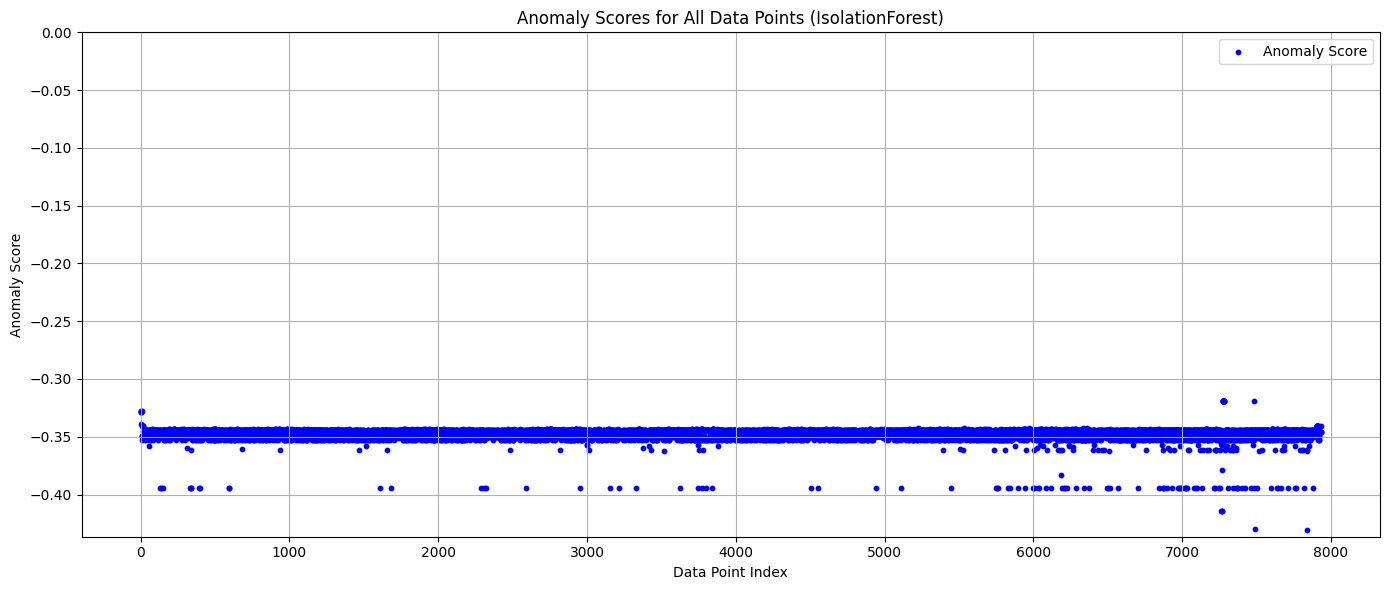

In [16]:
preds_2_5 = IF.predict(df_2_5_scaled)
scores_2_5 = IF.score_samples(df_2_5_scaled)

df_2_5_scaled_result = pd.DataFrame()
df_2_5_scaled_result['prediction'] = preds_2_5
df_2_5_scaled_result['anomaly_score'] = scores_2_5


anomaly_2_5 = (df_2_5_scaled_result["prediction"] == -1).sum()
normal_2_5 = (df_2_5_scaled_result["prediction"] == 1).sum()

print("\n" , f"Detection distribution anomaly/normal: {anomaly_2_5 / len(df_2_5_scaled_result) * 100:.4f}% / {normal_2_5 / len(df_2_5_scaled_result) * 100:.4f}%")
print("!!! Wyniki pokazuje dopasowanie contamination (wyciagancia wnioskow z gotowego produktu pracy modelu) NIE DCHYLENIA NORMALNY/ANOMALYJNY ruch sieciowy !!!")
print("Anomaly detected: ",anomaly_2_5)
print("Normal traffic: ",normal_2_5)
plt.figure(figsize=(14, 6))

plt.scatter(df_2_5_scaled_result.index, df_2_5_scaled_result['anomaly_score'], color='blue', label='Anomaly Score', s=10)

plt.title('Anomaly Scores for All Data Points (IsolationForest)')
plt.xlabel('Data Point Index')
plt.ylabel('Anomaly Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim(top=0)
plt.show()


<div style="margin-left: 38px; font-size: 30px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 20px; line-height: 1.6;">
    <div>2.2 Wizualizacja efektu testu na danych Tuesday-workingHours</div>
</div>

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    6.4s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    8.1s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    6.4s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    8.1s finished


Detection distribution anomaly/normal: 1.0540% / 98.9460%
!!! Wyniki pokazuje dopasowanie contamination (wyciagania wnioskow z gotowego produktu pracy modelu) NIE DCHYLENIA NORMALNY/ANOMALYJNY ruch sieciowy !!!
Anomaly detected: 4697
Normal traffic: 440948


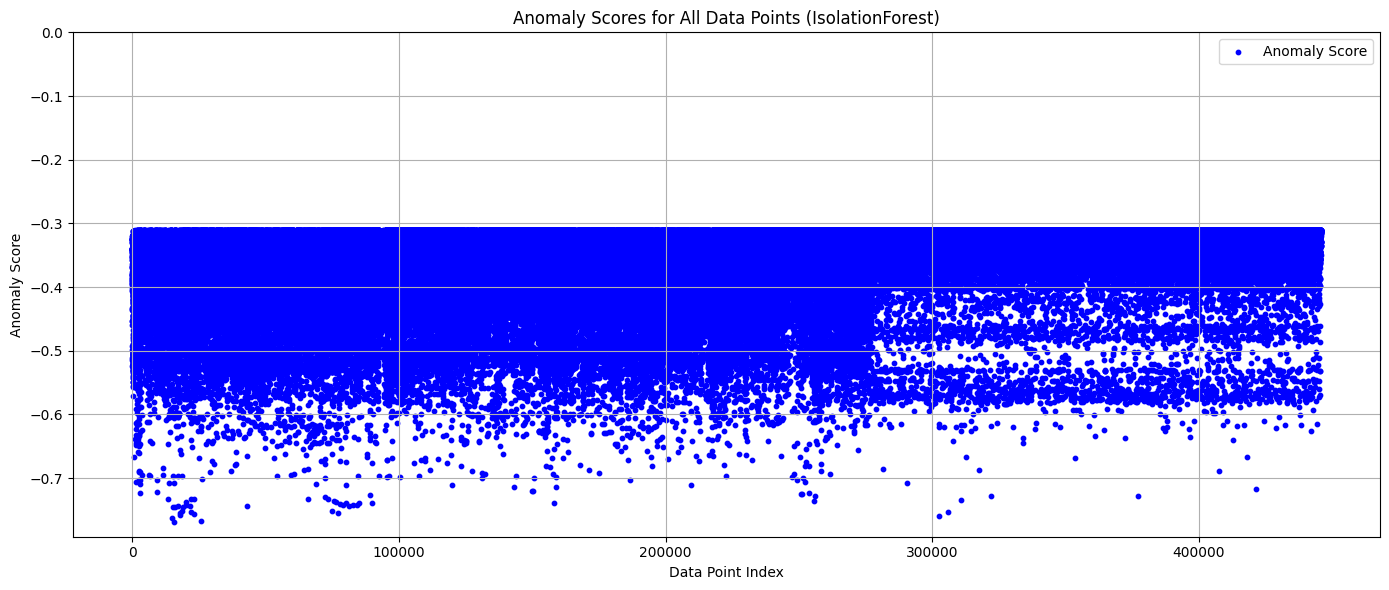

In [17]:
preds_2 = IF.predict(df_2_scaled)
scores_2 = IF.score_samples(df_2_scaled)

df_2_scaled_result = pd.DataFrame()
df_2_scaled_result['prediction'] = preds_2
df_2_scaled_result['anomaly_score'] = scores_2


anomaly_2 = (df_2_scaled_result["prediction"] == -1).sum()
normal_2 = (df_2_scaled_result["prediction"] == 1).sum()

log( f"2.2 Wizualizacja efektu testu na danych Tuesday-workingHours", level="start")
log(f"Detection distribution anomaly/normal: {anomaly_2 / len(df_2_scaled_result) * 100:.4f}% / {normal_2 / len(df_2_scaled_result) * 100:.4f}%")
log("!!! Wyniki pokazuje dopasowanie contamination (wyciagania wnioskow z gotowego produktu pracy modelu) NIE DCHYLENIA NORMALNY/ANOMALYJNY ruch sieciowy !!!")
log(f"Anomaly detected: {anomaly_2}")
log(f"Normal traffic: {normal_2}")

plt.figure(figsize=(14, 6))  # szeroki wykres

plt.scatter(df_2_scaled_result.index, df_2_scaled_result['anomaly_score'], color='blue', label='Anomaly Score', s=10)

plt.title('Anomaly Scores for All Data Points (IsolationForest)')
plt.xlabel('Data Point Index')
plt.ylabel('Anomaly Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim(top=0)
plt.show()

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    7.9s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    9.9s finished


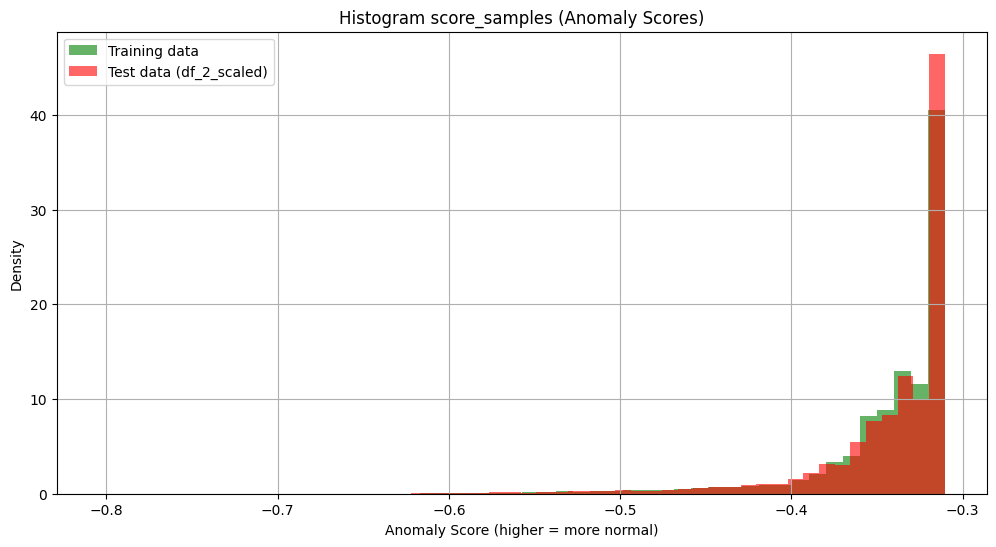

In [18]:
scores_train = IF.score_samples(df_scaled)

# score_samples dla danych testowych (z anomaliami)
scores_test = scores_2

plt.figure(figsize=(12,6))

# Histogram dla danych treningowych
plt.hist(scores_train, bins=50, alpha=0.6, label='Training data', color='green', density=True)

# Histogram dla danych testowych
plt.hist(scores_test, bins=50, alpha=0.6, label='Test data (df_2_scaled)', color='red', density=True)

plt.title('Histogram score_samples (Anomaly Scores)')
plt.xlabel('Anomaly Score (higher = more normal)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

<div style="margin-left: 38px; font-size: 30px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 20px; line-height: 1.6;">
    <div>2.3 Sprawdzenie dokładniści wytrenowanego modelu na Tuesday-workingHours</div>
</div>

In [19]:
df_2_scaled_result_check = pd.concat([df_2_scaled,df_2_scaled_result, df_2_labels], axis=1)
#print(len(df_2_scaled_result),len(df_2_labels),len(df_2_scaled_result_check))
# print(df_2_scaled_result.index)
# print(df_2_labels.index)
# print(df_2_scaled_result_check.head)
log("2.3 Sprawdzenie dokładniści wytrenowanego modelu na Tuesday-workingHours",level = "start")
log(f"Number of flows in Tuesday - Working Hours: {len(df_2_scaled_result_check)}")

df_2_real_anomaly_count = (df_2_scaled_result_check["Label"] != "BENIGN").sum()

log("Correct data: ")
log(f"Real number of anomalies in Tuesday - Working Hours: {df_2_real_anomaly_count}")
log(f"Procentage of anomlys in dataset: {df_2_real_anomaly_count / len(df_2_scaled_result_check) * 100:.4f}%")

df_2_predicted_anomaly_count = (df_2_scaled_result_check["prediction"] == -1).sum()

log("Predicted data: ")
log(f"Number of DETECTED anomalies in Tuesday - Working Hours: {df_2_predicted_anomaly_count}")
log(f"Procentage of anomlys in dataset: {df_2_predicted_anomaly_count / len(df_2_scaled_result_check) * 100:.4f}%")

TP = ((df_2_scaled_result_check["Label"] != "BENIGN") & (df_2_scaled_result_check["prediction"] == -1)).sum()
FP = df_2_predicted_anomaly_count - TP
FN = df_2_real_anomaly_count - TP
TN = len(df_2_scaled_result_check) - TP - FP - FN

log(f"\nNumber of correct predictions: {TP}")
log(f"Accuracy of predictions: {((TP + TN) / len(df_2_scaled_result_check)) * 100:.4f}%")
log(f"Sensitivity of predictions: {(TP / df_2_real_anomaly_count) * 100:.4f}%")
log(f"Precision of predictions: {(TP / df_2_predicted_anomaly_count) * 100:.4f}%")

# print("TP: ",TP)
# print("FP: ",FP)
# print("TN: ",TN)
# print("FN: ",FN)

# pd.set_option('display.max_rows', 200)
# print(df_2_scaled_result_check[df_2_scaled_result_check["prediction"] == -1])
# pd.reset_option('display.max_rows')

Number of flows in Tuesday - Working Hours: 445645
Correct data: 
Real number of anomalies in Tuesday - Working Hours: 13832
Procentage of anomlys in dataset: 3.1038%
Predicted data: 
Number of DETECTED anomalies in Tuesday - Working Hours: 4697
Procentage of anomlys in dataset: 1.0540%

Number of correct predictions: 0
Accuracy of predictions: 95.8422%
Sensitivity of predictions: 0.0000%
Precision of predictions: 0.0000%


<div style="margin-left: 38px; font-size: 30px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 20px; line-height: 1.6;">
    <div>3.1 Wizualizacja efektu testu na danych Wednesday-WorkingHours - Tylko ataki</div>
</div>

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    2.1s finished


Detection distribution anomaly/normal: 59.3847% / 40.6153%
!!! Wyniki pokazuje dopasowanie contamination (wyciagancia wnioskow z gotowego produktu pracy modelu) NIE DCHYLENIA NORMALNY/ANOMALYJNY ruch sieciowy !!!
Anomaly detected: 149485
Normal traffic: 102238


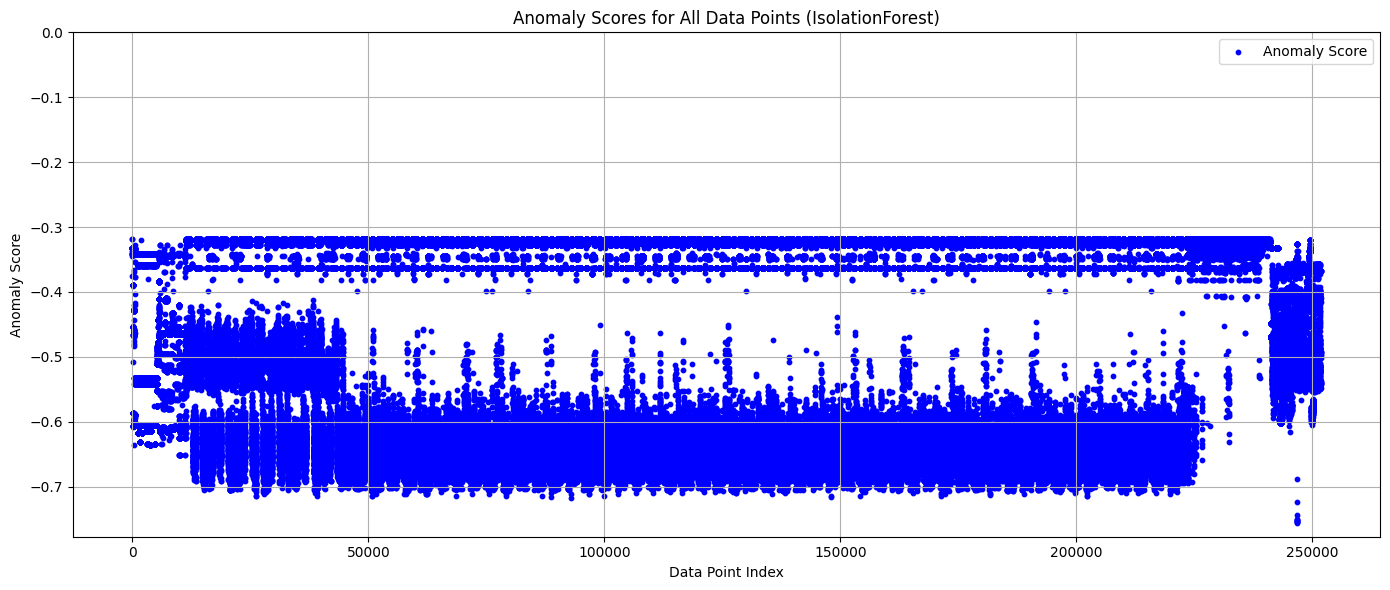

In [20]:
preds_3_5 = IF.predict(df_3_5_scaled)
scores_3_5 = IF.score_samples(df_3_5_scaled)

df_3_5_scaled_result = pd.DataFrame()
df_3_5_scaled_result['prediction'] = preds_3_5
df_3_5_scaled_result['anomaly_score'] = scores_3_5


anomaly_3_5 = (df_3_5_scaled_result["prediction"] == -1).sum()
normal_3_5 = (df_3_5_scaled_result["prediction"] == 1).sum()

print(f"Detection distribution anomaly/normal: {anomaly_3_5 / len(df_3_5_scaled_result) * 100:.4f}% / {normal_3_5 / len(df_3_5_scaled_result) * 100:.4f}%")
print("!!! Wyniki pokazuje dopasowanie contamination (wyciagancia wnioskow z gotowego produktu pracy modelu) NIE DCHYLENIA NORMALNY/ANOMALYJNY ruch sieciowy !!!")
print(f"Anomaly detected: {anomaly_3_5}")
print(f"Normal traffic: {normal_3_5}")
plt.figure(figsize=(14, 6))

plt.scatter(df_3_5_scaled_result.index, df_3_5_scaled_result['anomaly_score'], color='blue', label='Anomaly Score', s=10)

plt.title('Anomaly Scores for All Data Points (IsolationForest)')
plt.xlabel('Data Point Index')
plt.ylabel('Anomaly Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim(top=0)
plt.show()


<div style="margin-left: 38px; font-size: 30px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 20px; line-height: 1.6;">
    <div>3.2 Wizualizacja efektu testu na danych Wednesday-WorkingHours</div>
</div>

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    8.8s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   11.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    8.6s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   10.8s finished


Detection distribution anomaly/normal: 22.8397% / 77.1603%
!!! Wyniki pokazuje dopasowanie contamination (wyciagania wnioskow z gotowego produktu pracy modelu) NIE DCHYLENIA NORMALNY/ANOMALYJNY ruch sieciowy !!!
Anomaly detected: 157915
Normal traffic: 533491


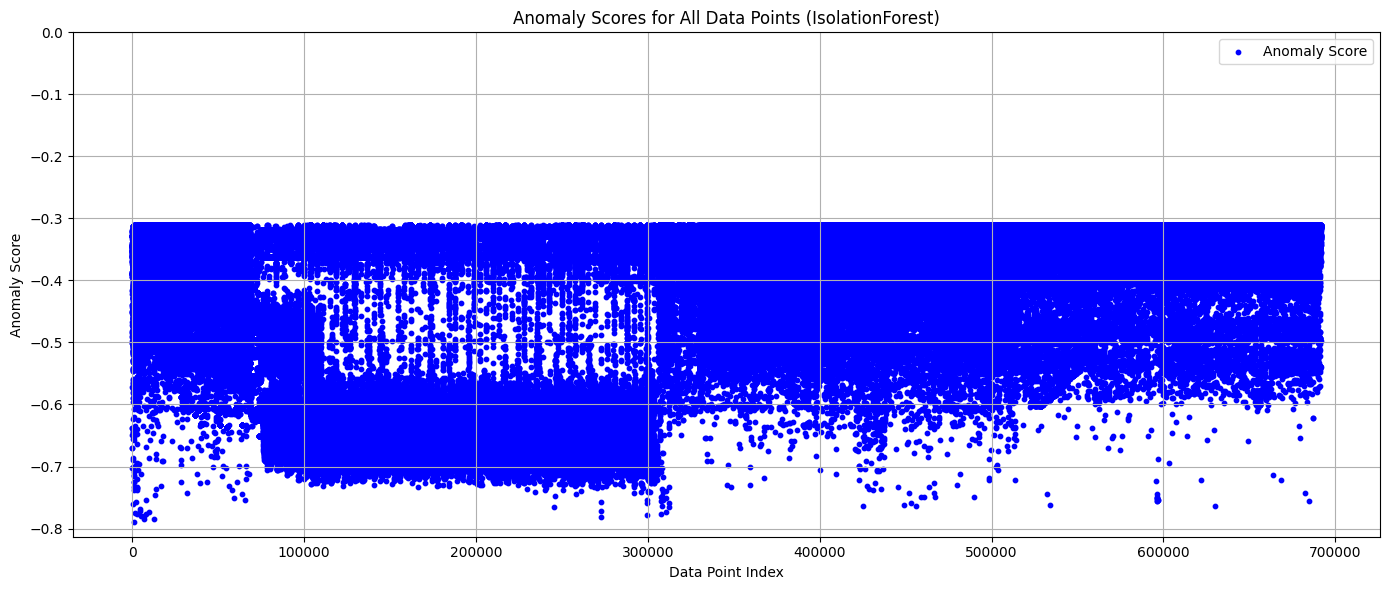

In [21]:
preds_3 = IF.predict(df_3_scaled)
scores_3 = IF.score_samples(df_3_scaled)

df_3_scaled_result = pd.DataFrame()
df_3_scaled_result['prediction'] = preds_3
df_3_scaled_result['anomaly_score'] = scores_3


anomaly_3 = (df_3_scaled_result["prediction"] == -1).sum()
normal_3 = (df_3_scaled_result["prediction"] == 1).sum()

log("3.2 Wizualizacja efektu testu na danych Wednesday-WorkingHours",level="start")
log(f"Detection distribution anomaly/normal: {anomaly_3 / len(df_3_scaled_result) * 100:.4f}% / {normal_3 / len(df_3_scaled_result) * 100:.4f}%")
log("!!! Wyniki pokazuje dopasowanie contamination (wyciagania wnioskow z gotowego produktu pracy modelu) NIE DCHYLENIA NORMALNY/ANOMALYJNY ruch sieciowy !!!")
log(f"Anomaly detected: {anomaly_3}")
log(f"Normal traffic: {normal_3}")

plt.figure(figsize=(14, 6))  # szeroki wykres

plt.scatter(df_3_scaled_result.index, df_3_scaled_result['anomaly_score'], color='blue', label='Anomaly Score', s=10)

plt.title('Anomaly Scores for All Data Points (IsolationForest)')
plt.xlabel('Data Point Index')
plt.ylabel('Anomaly Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim(top=0)
plt.show()

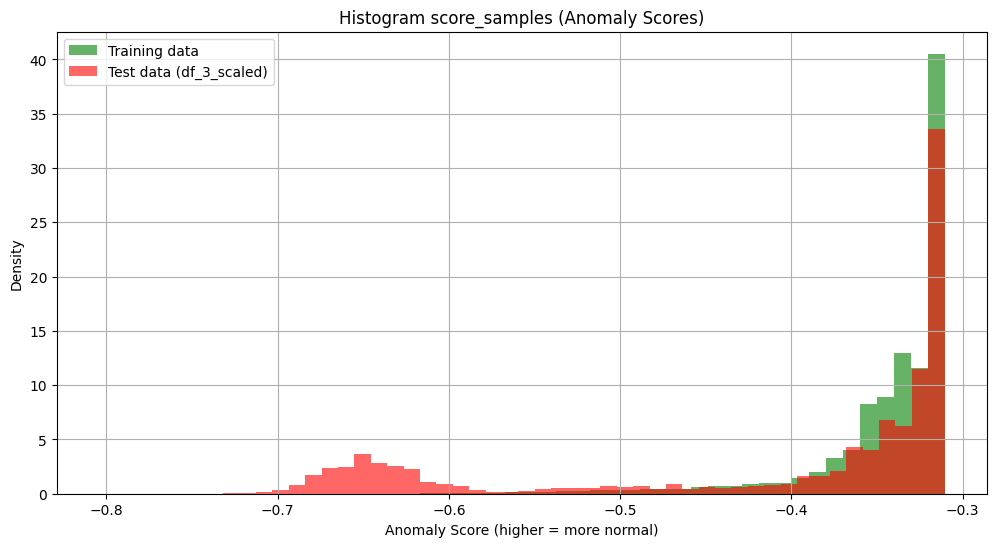

In [22]:
# score_samples dla danych testowych (z anomaliami)
scores_test = scores_3

plt.figure(figsize=(12,6))

# Histogram dla danych treningowych
plt.hist(scores_train, bins=50, alpha=0.6, label='Training data', color='green', density=True)

# Histogram dla danych testowych
plt.hist(scores_test, bins=50, alpha=0.6, label='Test data (df_3_scaled)', color='red', density=True)

plt.title('Histogram score_samples (Anomaly Scores)')
plt.xlabel('Anomaly Score (higher = more normal)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

<div style="margin-left: 38px; font-size: 30px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 20px; line-height: 1.6;">
    <div>3.3 Sprawdzenie dokładniści wytrenowanego modelu na Wednesday-WorkingHours</div>
</div>

In [23]:
df_3_scaled_result_check = pd.concat([df_3_scaled,df_3_scaled_result, df_3_labels], axis=1)

# print(len(df_3_scaled_result),len(df_3_labels),len(df_3_scaled_result_check))
# print(df_3_scaled_result.index)
# print(df_3_scaled.index)
# print(df_3_labels.index)
# print(df_3_scaled_result_check.isna().any(axis=0).sum(), len(df_unrecognized))
# print(df_3_labels.isna().any().sum(), len(df_unrecognized))
# print(df_3_scaled.isna().any(axis=0).sum(),len(df_filtered_result))
# print(df_3_scaled_result.isna().any(axis=0).sum(),len(df_filtered_labeled))
log("3.3 Sprawdzenie dokładniści wytrenowanego modelu na Wednesday-WorkingHours",level="start")

log(f"Number of flows in Wednesday - Working Hours: {len(df_3_scaled_result_check)}")

df_3_real_anomaly_count = (df_3_scaled_result_check["Label"] != "BENIGN").sum()

log("Correct data: ")
log(f"Real number of anomalies in Wednesday - Working Hours: {df_3_real_anomaly_count}")
log(f"Procentage of anomlys in dataset: {df_3_real_anomaly_count / len(df_3_scaled_result_check) * 100:.4f}%")

df_3_predicted_anomaly_count = (df_3_scaled_result_check["prediction"] == -1).sum()

log("Predicted data: ")
log("Number of DETECTED anomalies in Wednesday - Working Hours: ", df_3_predicted_anomaly_count)
log(f"Procentage of anomlys in dataset: {df_3_predicted_anomaly_count / len(df_3_scaled_result_check) * 100:.4f}%")


TP = ((df_3_scaled_result_check["Label"] != "BENIGN") & (df_3_scaled_result_check["prediction"] == -1)).sum()
FP = df_3_predicted_anomaly_count - TP
FN = df_3_real_anomaly_count - TP
TN = len(df_3_scaled_result_check) - TP - FP - FN

log(f"\nNumber of correct predictions: { TP}")
log(f"Accuracy of predictions: {((TP + TN) / len(df_3_scaled_result_check)) * 100:.4f}%")
log(f"Sensitivity of predictions: {(TP / df_3_real_anomaly_count) * 100:.4f}%")
log(f"Precision of predictions: {(TP / df_3_predicted_anomaly_count) * 100:.4f}%")



# pd.set_option('display.max_rows', 200)
# print(df_3_scaled_result_check[df_3_scaled_result_check["prediction"] == -1])
# pd.reset_option('display.max_rows')

Number of flows in Wednesday - Working Hours: 691406
Correct data: 
Real number of anomalies in Wednesday - Working Hours: 251723
Procentage of anomlys in dataset: 36.4074%
Predicted data: 
Number of DETECTED anomalies in Wednesday - Working Hours: 
Procentage of anomlys in dataset: 22.8397%

Number of correct predictions: 149485
Accuracy of predictions: 83.9938%
Sensitivity of predictions: 59.3847%
Precision of predictions: 94.6617%


<div style="margin-left: 38px; font-size: 30px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 20px; line-height: 1.6;">
    <div>3.4 Analiza niewyłapanych ataków Wednesday-WorkingHours</div>
</div>

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    2.1s finished


102238 251723


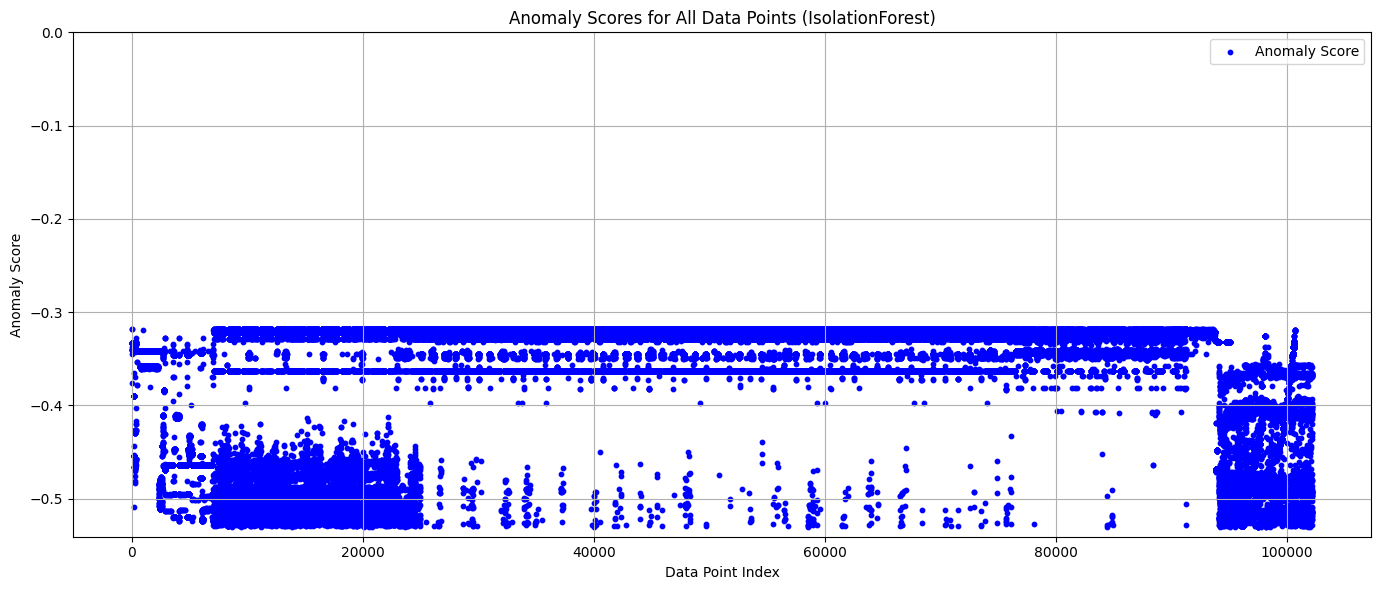

In [24]:
df_3_real_anomaly = df_3_scaled_result_check[df_3_scaled_result_check["Label"] != "BENIGN"]
df_3_real_anomaly = df_3_real_anomaly.reset_index(drop=True)
df_3_real_anomaly_no_label = df_3_real_anomaly.drop(["Label",'prediction','anomaly_score'], axis = 1)

preds_3_real = IF.predict(df_3_real_anomaly_no_label)
scores_3_real = IF.score_samples(df_3_real_anomaly_no_label)


df_3_real_anomaly['prediction'] = preds_3_real
df_3_real_anomaly['anomaly_score'] = scores_3_real

print((df_3_real_anomaly['prediction'] == 1).sum(), len(df_3_real_anomaly))
df_3_real_anomaly = df_3_real_anomaly[df_3_real_anomaly['prediction'] != -1]
df_3_real_anomaly = df_3_real_anomaly.reset_index(drop=True)

plt.figure(figsize=(14, 6))  # szeroki wykres

plt.scatter(df_3_real_anomaly.index, df_3_real_anomaly['anomaly_score'], color='blue', label='Anomaly Score', s=10)

plt.title('Anomaly Scores for All Data Points (IsolationForest)')
plt.xlabel('Data Point Index')
plt.ylabel('Anomaly Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim(top=0)
plt.show()

<div style="margin-left: 38px; font-size: 30px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 20px; line-height: 1.6;">
    <div>4 Sprawdzenie dokładności modelu na Thursday</div>
</div>

<div style="text-align: center;color:#66ff7d; font-size: 50px; font-family: 'OCR A Extended', 'Lucida Console', 'Monaco', monospace; margin-top: 20px; line-height: 1.6;">
    DEBUGGING TESTS
</div>

In [25]:
# columns_to_plot = df_2_scaled.columns[:4]  # wybieramy np. 4 pierwsze kolumny do porównania

# fig, axes = plt.subplots(2, len(columns_to_plot), figsize=(5 * len(columns_to_plot), 8))
# fig.suptitle("Porównanie df_2_scaled (góra) vs df_2_5_scaled (dół)", fontsize=16)

# for i, col in enumerate(columns_to_plot):
#     # Wykres df_2_scaled
#     axes[0, i].plot(df_2_scaled[col].values, color='blue')
#     axes[0, i].set_title(f"df_2_scaled - {col}", fontsize=10)

#     # Wykres df_2_5_scaled
#     axes[1, i].plot(df_2_5_scaled[col].values, color='orange')
#     axes[1, i].set_title(f"df_2_5_scaled - {col}", fontsize=10)

# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.show()

In [26]:
preds_4 = IF.predict(df_3_5_scaled.iloc[0:2])
print(preds_4)

[1 1]


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished
